In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from ipywidgets import interact, fixed, IntSlider, Checkbox
from pathlib import Path
# Instalamos el paquete de utilidades
%pip install -qq git+https://github.com/udesa-vision/i308-utils.git

from i308_utils import imshow, show_images
from utils import rectify_stereo_pair, draw_epipolar_lines, show_pair_any_budha, compute_depth

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Cargamos los archivos y analizamos el contenido
with open('data/pkls/stereo_calibration.pkl', 'rb') as f:
    calib = pickle.load(f)

with open('data/pkls/stereo_maps.pkl', 'rb') as f:
    maps = pickle.load(f)

print('Calibration keys:', calib.keys())
print('Maps keys:', maps.keys())

Calibration keys: dict_keys(['left_K', 'left_dist', 'right_K', 'right_dist', 'R', 'T', 'E', 'F', 'image_size'])
Maps keys: dict_keys(['left_map_x', 'left_map_y', 'right_map_x', 'right_map_y', 'R1', 'R2', 'P1', 'P2', 'Q', 'validRoi1', 'validRoi2'])


Pares rectificados: 20


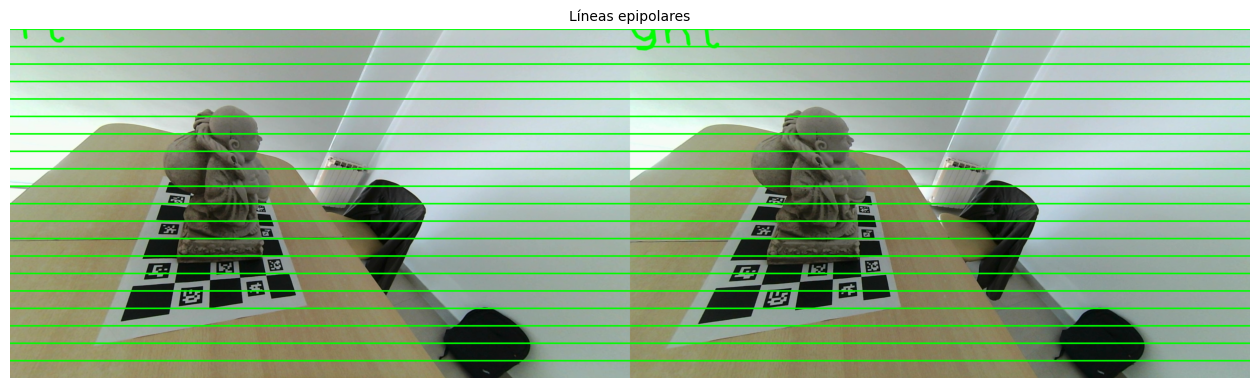

In [3]:
# Rectificamos los pares estéreo
in_dir = Path('data/stereo_budha_charuco/captures')
out_dir = Path('data/stereo_budha_charuco/rectified')
out_dir.mkdir(exist_ok=True)

indices = list(range(0, 20))
desired_indices = [14, 15, 16, 17, 18]

rectified_pairs = {}
procesados = 0
faltantes = []

for i in indices:
    left_path = in_dir / f'left_{i}.jpg'
    right_path = in_dir / f'right_{i}.jpg'
    if not left_path.exists() or not right_path.exists():
        faltantes.append(i)
        continue

    rectL, rectR = rectify_stereo_pair(str(left_path), str(right_path), maps)

    rectified_pairs[i] = (rectL, rectR)

    # Guardar
    cv2.imwrite(str(out_dir / f'rect_left_{i}.jpg'), rectL)
    cv2.imwrite(str(out_dir / f'rect_right_{i}.jpg'), rectR)
    procesados += 1

print(f'Pares rectificados: {procesados}')
if faltantes:
    print('Índices faltantes:', faltantes)

available_indices = sorted(rectified_pairs.keys())
selected_indices = [idx for idx in desired_indices if idx in rectified_pairs]
if len(selected_indices) < 3:
    fallback_count = min(5, max(3, len(available_indices)))
    selected_indices = available_indices[:fallback_count]

if len(selected_indices) == 0:
    raise RuntimeError('No hay pares rectificados disponibles para trabajar.')

sample_idx = selected_indices[0]
rectL, rectR = rectified_pairs[sample_idx]

# Visualizamos un par de imágenes rectificadas con líneas epipolares
combinados = draw_epipolar_lines(rectL, rectR)
imshow(combinados, title='Líneas epipolares', figsize=(16, 8))


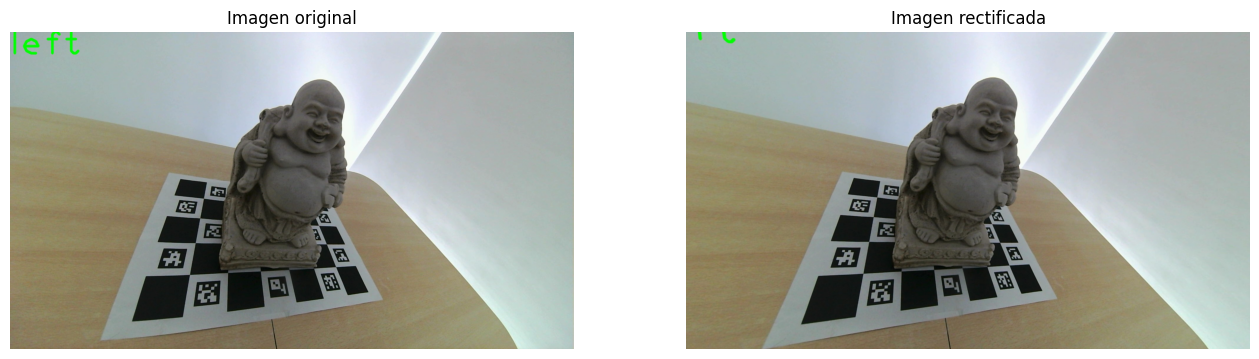

In [4]:
imgL = cv2.imread('data/stereo_budha_charuco/captures/left_0.jpg')
rectifiedL = cv2.remap(imgL, maps['left_map_x'], maps['left_map_y'], cv2.INTER_LINEAR)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.title('Imagen original')
plt.imshow(cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Imagen rectificada')
plt.imshow(cv2.cvtColor(rectifiedL, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [5]:
idx_slider = IntSlider(min=0, max=20, step=1, value=14, layout={'width': '900px'})
lines_slider = IntSlider(min=5, max=50, step=5, value=20, layout={'width': '400px'})

interact(
    show_pair_any_budha,
    idx=idx_slider,
    draw_lines=Checkbox(value=True, description='Rectificar'),
    num_lines=lines_slider,
    stereo_maps=fixed(maps)
)

interactive(children=(IntSlider(value=14, description='idx', layout=Layout(width='900px'), max=20), Checkbox(v…

<function utils.show_pair_any_budha(idx=14, rectificar=True, num_lines=20, stereo_maps=None)>

## Cálculo de Disparidad
### Block Matching

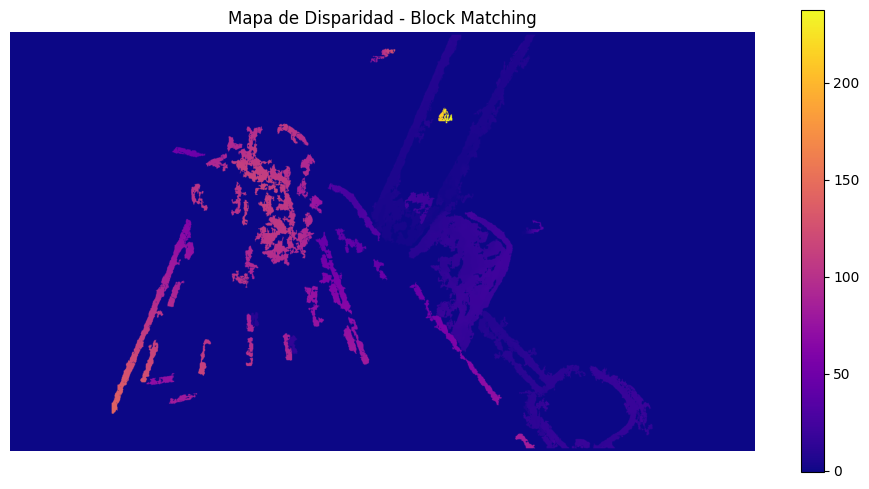

In [6]:
stereo_bm = cv2.StereoBM_create(numDisparities=256, blockSize=15)

stereo_bm.setPreFilterSize(31)
stereo_bm.setPreFilterCap(15)
stereo_bm.setMinDisparity(0)
stereo_bm.setTextureThreshold(7)
stereo_bm.setUniquenessRatio(3)
stereo_bm.setSpeckleWindowSize(512)
# stereo_bm.setSpeckleWindowSize(0)
stereo_bm.setSpeckleRange(32)
stereo_bm.setDisp12MaxDiff(23)

# Pasamos las imágenes rectificadas a escala de grises (vista de ejemplo)
rectL_gray = cv2.cvtColor(rectL, cv2.COLOR_BGR2GRAY)
rectR_gray = cv2.cvtColor(rectR, cv2.COLOR_BGR2GRAY)

# Cálculo del mapa de disparidad
disparity_map_bm = stereo_bm.compute(
    rectL_gray,
    rectR_gray
).astype(np.float32) / 16.0

plt.figure(figsize=(12, 6))
plt.imshow(disparity_map_bm, cmap='plasma')
plt.colorbar()
plt.title('Mapa de Disparidad - Block Matching')
plt.axis('off')
plt.show()


### Semi-Global Block Matching

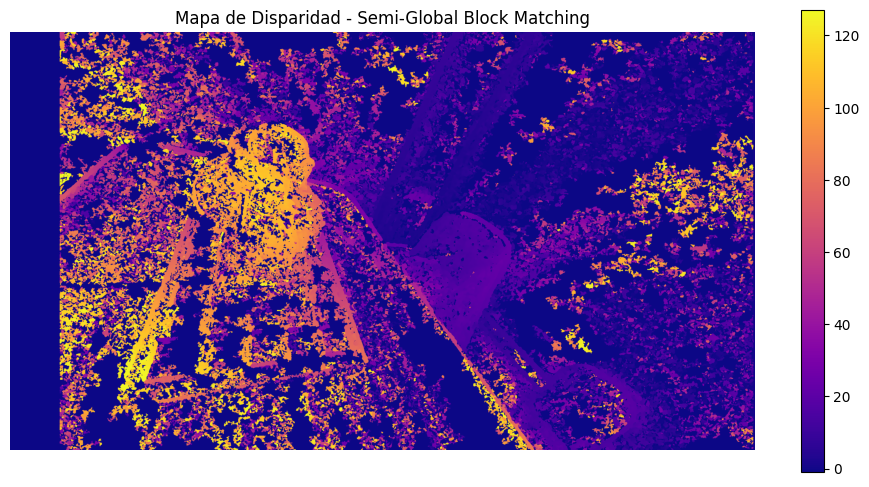

In [7]:
stereo_sgbm = cv2.StereoSGBM_create(numDisparities=128, blockSize=7)

# stereo_sgbm.setBlockSize(3)
# stereo_sgbm.setMode()

stereo_sgbm.setP1(16)
stereo_sgbm.setP2(128)
stereo_sgbm.setUniquenessRatio(7)
stereo_sgbm.setSpeckleWindowSize(512)
stereo_sgbm.setSpeckleRange(64)
stereo_sgbm.setDisp12MaxDiff(1)
stereo_sgbm.setPreFilterCap(63)

# Cálculo del mapa de disparidad (vista de ejemplo)
disparity_map_sgbm = stereo_sgbm.compute(
    rectL_gray,
    rectR_gray
).astype(np.float32) / 16.0

plt.figure(figsize=(12, 6))
plt.imshow(disparity_map_sgbm, cmap='plasma')
plt.colorbar()
plt.title('Mapa de Disparidad - Semi-Global Block Matching')
plt.axis('off')
plt.show()


### Cre Stereo

In [8]:
%pip install -qq onnxruntime

Note: you may need to restart the kernel to use updated packages.


In [9]:
width, height = rectL_gray.shape[1], rectL_gray.shape[0]

fx = calib['left_K'][0][0]
fy = calib['left_K'][1][1]
cx0 = calib['left_K'][0][2]
cy0 = calib['left_K'][1][2]

baseline = np.linalg.norm(calib['T'])  # Distancia entre cámaras


In [10]:
from disparity.methods import Calibration, InputPair, Config
from disparity.method_cre_stereo import CREStereo

def to_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

calibration = Calibration(**{
    "width": width,
    "height": height,
    "baseline_meters": baseline / 1000,
    "fx": fx,
    "fy": fy,
    "cx0": cx0,
    "cx1": cx0,
    "cy": cy0,
    "depth_range": [0.05, 20.0],
    "left_image_rect_normalized": [0, 0, 1, 1]
})

models_path = "models"
if not os.path.exists(models_path):
    os.makedirs(models_path)
models_path = Path(models_path)

config = Config(models_path=models_path)
cre_stereo = CREStereo(config)
cre_stereo.parameters['Shape'].set_value('1280x720')

disparity_maps_cs = {}
for idx in selected_indices:
    left_img, right_img = rectified_pairs[idx]
    pair = InputPair(
        left_image=to_gray(left_img),
        right_image=to_gray(right_img),
        calibration=calibration
    )
    disparity_result = cre_stereo.compute_disparity(pair)
    disparity_maps_cs[idx] = disparity_result.disparity_pixels.astype(np.float32)

# Visualizamos la disparidad de la vista de ejemplo
disparity_map_cs_px = disparity_maps_cs[sample_idx]

plt.figure(figsize=(12, 6))
plt.imshow(disparity_map_cs_px, cmap='plasma')
plt.colorbar()
plt.title(f'Mapa de Disparidad - CRE Stereo (vista {sample_idx})')
plt.axis('off')
plt.show()


models/crestereo_combined_iter5_720x1280.onnx


URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:992)>

### Cálculo de Profundidad

Usamos la fórmula:
$ z = \frac{f . B}{d} $

In [ ]:
f = calib['left_K'][0][0]  # Focal en píxeles
B = baseline

depth_maps_cs_px = {
    idx: compute_depth(disp, f, B)
    for idx, disp in disparity_maps_cs.items()
}

depth_map_cs_px = depth_maps_cs_px[sample_idx]

plt.figure(figsize=(12, 6))
plt.imshow(depth_map_cs_px, cmap='plasma')
plt.colorbar()
plt.title(f'Mapa de Profundidad - CRE Stereo (vista {sample_idx})')
plt.axis('off')
plt.show()


In [ ]:
depth_map_cs_px2 = depth_map_cs_px.copy()
depth_map_cs_px2[depth_map_cs_px2 > 10000] = 10000

plt.figure(figsize=(12, 6))
plt.imshow(depth_map_cs_px2, cmap='plasma')
plt.colorbar()
plt.title('Mapa de Profundidad Recortado - CRE Stereo')
plt.axis('off')
plt.show()

# Detección de patrón y pose


In [ ]:
# ==========================================
# B) Helpers de compatibilidad (clave)
# ==========================================
def _board_dictionary(board, default=cv2.aruco.DICT_6X6_250):
    """Devuelve el diccionario ArUco del board (atributo o método, según versión)."""
    try:
        return board.dictionary
    except AttributeError:
        try:
            return board.getDictionary()
        except AttributeError:
            return cv2.aruco.getPredefinedDictionary(default)

def _board_ids(board):
    """Devuelve np.array (N,) de ids de marcadores del board."""
    try:
        return np.array(board.ids).ravel()
    except AttributeError:
        return np.array(board.getIds()).ravel()

def _board_objpoints(board):
    """Devuelve lista de (4,3) en METROS, alineada con _board_ids(board)."""
    try:
        ops = board.objPoints
    except AttributeError:
        ops = board.getObjPoints()
    return [op.reshape(-1,3) for op in ops]

In [ ]:
#ya teniendo el mapa de profundidad, podemos encontrar la nube de puntos 3D
#para eso necesitamos la matriz Q de reproyección, que se obtiene a partir de la rectificacion

#primero debo encontrar la pose de la camara izquierda con respercto al mundo 
#se calcula en relacion a un patron conocido 
#usar cv.findChessboardCorners y cv.solvePnP


def show_images(img_list, cols=2, title=None):
    n = len(img_list)
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(6*cols, 5*rows))
    for i, im in enumerate(img_list):
        plt.subplot(rows, cols, i+1)
        if im.ndim == 3:
            plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(im, cmap='gray')
        plt.axis('off')
    if title:
        plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


def create_charuco_board(
        squares_x=5,
        squares_y=7,
        square_length=0.04,   # metros
        marker_length=0.02,   # metros
        dictionary_type=cv2.aruco.DICT_6X6_250
):
    """Devuelve un cv2.aruco.CharucoBoard (OpenCV usa METROS)."""
    aruco_dict = cv2.aruco.getPredefinedDictionary(dictionary_type)
    board = cv2.aruco.CharucoBoard((squares_x, squares_y), square_length, marker_length, aruco_dict)
    return board


def detect_charuco_markers(image, board, detector_params=None):
    """
    Detecta marcadores ArUco (para Charuco). Devuelve dict con corners/ids/rejected.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if image.ndim == 3 else image

    if detector_params is None:
        try:
            detector_params = cv2.aruco.DetectorParameters()
        except Exception:
            detector_params = cv2.aruco.DetectorParameters_create()

    aruco_dict = _board_dictionary(board)  # <--- Compatibilidad

    if hasattr(cv2.aruco, "ArucoDetector"):
        detector = cv2.aruco.ArucoDetector(aruco_dict, detector_params)
        corners, ids, rejected = detector.detectMarkers(gray)
    else:
        corners, ids, rejected = cv2.aruco.detectMarkers(gray, aruco_dict, parameters=detector_params)

    if ids is None or len(ids) == 0:
        return None

    return {'corners': corners, 'ids': ids, 'rejected': rejected}

def draw_aruco_results(image, detection_result, size=5):
    if len(image.shape) == 2:
        result = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    else:
        result = image.copy()

    if detection_result is None:
        return result

    corners = detection_result["corners"]
    ids = detection_result["ids"]

    if corners is not None and len(corners) > 0:
        ids = ids.flatten()
        for (markerCorner, markerID) in zip(corners, ids):
            pts = markerCorner.reshape((4, 2))
            (tl, tr, br, bl) = pts
            tl = (int(tl[0]), int(tl[1])); tr = (int(tr[0]), int(tr[1]))
            br = (int(br[0]), int(br[1])); bl = (int(bl[0]), int(bl[1]))
            cv2.line(result, tl, tr, (0, 0, 255), size)
            cv2.line(result, tr, br, (0, 255, 0), size)
            cv2.line(result, br, bl, (255, 0, 0), size)
            cv2.line(result, bl, tl, (0, 255, 255), size)
            cX = int((tl[0] + br[0]) / 2.0); cY = int((tl[1] + br[1]) / 2.0)
            cv2.circle(result, (cX, cY), 3 * size, (0, 0, 255), -1)
            org = (cX + 15, max(cY + 30, 0))
            cv2.putText(result, str(markerID), org, cv2.FONT_HERSHEY_SIMPLEX, size, (0, 0, 0), size+10)
            cv2.putText(result, str(markerID), org, cv2.FONT_HERSHEY_SIMPLEX, size, (0, 255, 0), size+3)
    return result

def estimate_camera_pose_with_homography(
        image,
        board,
        detection,
        calibration,
        undistort=False
):
    """
    Estima homografía (XY del tablero -> imagen) y la descompone a (rvec, tvec).
    Devuelve (ok, rvec, tvec) con tvec en METROS.
    """
    if detection is None:
        return (False, None, None)

    corners_list = detection['corners']  # lista de (1,4,2)
    ids          = detection['ids']      # (N,1)
    K, dist      = calibration

    if ids is None or len(ids) < 4:
        return (False, None, None)

    b_ids = _board_ids(board)           # (Nb,)
    b_ops = _board_objpoints(board)     # lista Nb de (4,3)
    id2idx = {int(k): i for i, k in enumerate(b_ids)}  # mapeo id -> índice (rápido y claro)

    image_points, board_points = [], []
    for mcorners, mid in zip(corners_list, ids.ravel()):
        mid = int(mid)
        if mid not in id2idx:
            continue
        j = id2idx[mid]
        obj_marker_3d = b_ops[j]                  # (4,3) METROS
        img_marker_2d = mcorners.reshape(-1, 2)   # (4,2)
        board_points.append(obj_marker_3d[:, :2]) # XY
        image_points.append(img_marker_2d)

    if len(image_points) == 0:
        return (False, None, None)

    image_points = np.concatenate(image_points, axis=0).astype(np.float32)  # (4*K,2)
    board_points = np.concatenate(board_points, axis=0).astype(np.float32)  # (4*K,2)

    if image_points.shape[0] < 4:
        return (False, None, None)

    if undistort:
        image_points = cv2.undistortPoints(image_points.reshape(-1,1,2), K, dist, P=K).reshape(-1,2)

    H, inliers = cv2.findHomography(board_points, image_points, method=cv2.LMEDS)
    if H is None:
        return (False, None, None)

    # Descomponer H -> (R,t): H ~ K [r1 r2 t]
    Hn = np.linalg.inv(K) @ H
    h1, h2, h3 = Hn[:,0], Hn[:,1], Hn[:,2]
    lam = 1.0 / max(np.linalg.norm(h1), 1e-9)
    r1, r2 = h1 * lam, h2 * lam
    r3 = np.cross(r1, r2)
    R_approx = np.column_stack([r1, r2, r3])
    U, _, Vt = np.linalg.svd(R_approx)
    R = U @ Vt
    t = h3 * lam

    rvec, _ = cv2.Rodrigues(R.astype(np.float64))
    tvec    = t.reshape(3,1).astype(np.float64)  # METROS
    return (True, rvec, tvec)

In [ ]:
# =======================
# Entradas (rectificadas)
# =======================
left_img_rect = rectL
P1 = maps['P1']
Q = maps['Q']
disparity = disparity_map_cs_px
K = P1[:3, :3].copy().astype(np.float32)          # intrínsecos de la rectificada
dist = np.zeros((1,5), np.float32)                # rectificada => sin distorsión

# ======== imágenes (usa tus rectificadas) ========
images = [rectified_pairs[idx][0].copy() for idx in selected_indices]


In [ ]:
use_dict = cv2.aruco.DICT_6X6_250
squares_x = 5
squares_y = 7
square_length_mm = 30.0
marker_length_mm = 20.0
square_length = square_length_mm / 1000.0  # METROS
marker_length = marker_length_mm / 1000.0  # METROS

board = create_charuco_board(
    squares_x=squares_x, squares_y=squares_y,
    square_length=square_length,
    marker_length=marker_length,
    dictionary_type=use_dict
)


In [ ]:
# Paso 1: mostrar imágenes fuente
show_images(images, cols=2, title="Imágenes rectificadas de entrada")

# Paso 2: detección simple
results_det = []
for img in images:
    detection = detect_charuco_markers(img, board)
    result_img = draw_aruco_results(img, detection, size=3)
    results_det.append(result_img)
show_images(results_det, cols=2, title="Detección ArUco/ChArUco")

# Paso 3: pose con OpenCV (interpolateCornersCharuco + estimatePoseCharucoBoard)
# def estimate_pose_cv(img, board, detection, calibration):
#     K_use, dist_use = calibration
#     corners = detection['corners']
#     ids     = detection['ids']

#     # Ruta A: si tu OpenCV la tiene, usar Charuco (la más estable)
#     if hasattr(cv2.aruco, "interpolateCornersCharuco") and ids is not None and len(ids) > 0:
#         interp = cv2.aruco.interpolateCornersCharuco(
#             markerCorners=corners,
#             markerIds=ids,
#             image=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),
#             board=board
#         )
#         num, ch_corners, ch_ids = interp
#         if (ch_corners is not None) and (ch_ids is not None) and (num is not None) and (num >= 4):
#             pose = cv2.aruco.estimatePoseCharucoBoard(
#                 charucoCorners=ch_corners,
#                 charucoIds=ch_ids,
#                 board=board,
#                 cameraMatrix=K_use,
#                 distCoeffs=dist_use,
#                 rvec=np.empty(1),
#                 tvec=np.empty(1)
#             )
#             return pose  # (ok, rvec, tvec)

#     # Ruta B: fallback con sólo marcadores del board
#     if hasattr(cv2.aruco, "estimatePoseBoard") and ids is not None and len(ids) > 0:
#         retval, rvecB, tvecB = cv2.aruco.estimatePoseBoard(
#             corners, ids, board, K_use, dist_use, None, None
#         )
#         if retval and (tvecB is not None):
#             return True, rvecB, tvecB  # tvec en METROS (misma unidad que el board)

#     # Ruta C: último recurso, un solo marcador
#     if hasattr(cv2.aruco, "estimatePoseSingleMarkers") and ids is not None and len(ids) > 0:
#         # marker_length ya lo definiste arriba (en METROS)
#         rvecs, tvecs, _ = cv2.aruco.estimatePoseSingleMarkers(corners, marker_length, K_use, dist_use)
#         if rvecs is not None and len(rvecs) > 0:
#             return True, rvecs[0].reshape(3,1), tvecs[0].reshape(3,1)  # METROS

#     return (False, None, None)



def estimate_pose_cv(img, board, detection, calibration):
    K_use, dist_use = calibration
    corners = detection['corners']      # list de (1,4,2)
    ids     = detection['ids']          # (N,1)

    print('is_charuco:', hasattr(board,'getChessboardSize'))
    print('ids:', None if ids is None else (ids.shape, ids.dtype))
    print('corners[0]:', corners[0].shape, corners[0].dtype)

    is_charuco = hasattr(board, "getChessboardSize")  # CharucoBoard tiene este método

    # ===== Ruta A: ChArUco (preferida) =====
    if is_charuco and ids is not None and len(ids) > 0:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        num, ch_corners, ch_ids = cv2.aruco.interpolateCornersCharuco(
            markerCorners=corners,
            markerIds=ids,
            image=gray,
            board=board
        )
        if (num is not None) and (ch_corners is not None) and (ch_ids is not None) and (num >= 4):
            ok, rvec, tvec = cv2.aruco.estimatePoseCharucoBoard(
                ch_corners.astype(np.float32),
                ch_ids.astype(np.int32).reshape(-1,1),
                board, K_use, dist_use
            )
            if ok:
                return True, rvec, tvec

        # Fallback para ChArUco: 1 solo marcador
        if ids is not None and len(ids) > 0:
            corners_ok = [c.astype(np.float32) for c in corners]
            rvecs, tvecs, _ = cv2.aruco.estimatePoseSingleMarkers(
                corners_ok, marker_length, K_use, dist_use
            )
            if rvecs is not None and len(rvecs) > 0:
                return True, rvecs[0].reshape(3,1), tvecs[0].reshape(3,1)

        return False, None, None

    # ===== Ruta B: Board de marcadores (NO Charuco) =====
    if (not is_charuco) and ids is not None and len(ids) > 0:
        corners_ok = [c.astype(np.float32) for c in corners]
        ids_ok = ids.astype(np.int32).reshape(-1,1)
        retval, rvecB, tvecB = cv2.aruco.estimatePoseBoard(
            corners_ok, ids_ok, board, K_use, dist_use, None, None
        )
        if retval and (tvecB is not None):
            return True, rvecB, tvecB

    return False, None, None



results_pose_cv = []
for img in images:
    detection = detect_charuco_markers(img, board)
    pose = (False, None, None) if detection is None else estimate_pose_cv(img, board, detection, (K, dist))

    result_img = draw_aruco_results(img, detection, size=3)
    ok, rv, tv = pose
    if ok:
        cv2.drawFrameAxes(result_img, K, dist, rv, tv, square_length * 5)  # longitud en METROS
    results_pose_cv.append(result_img)
show_images(results_pose_cv, cols=2, title="Pose con OpenCV (Charuco)")

# Paso 4: pose robusta por homografía (tu función ajustada)
results_pose_h = []
for img in images:
    detection = detect_charuco_markers(img, board)
    pose = (False, None, None) if detection is None else estimate_camera_pose_with_homography(
        img, board, detection, (K, dist)
    )
    ok, rv, tv = pose

    result_img = draw_aruco_results(img, detection, size=3)
    if ok:
        cv2.drawFrameAxes(result_img, K, dist, rv, tv, square_length * 5)  # METROS
    results_pose_h.append(result_img)
show_images(results_pose_h, cols=2, title="Pose por homografía (ajustada)")

# Reconstrucción 3D

In [ ]:
# ===============================
# Pose de la cámara: rvec, tvec
# ===============================
# Requisitos ya definidos antes:
# left_img_rect = rectL
# board = create_charuco_board(...)
# K = P1[:3,:3].astype(np.float32); dist = np.zeros((1,5), np.float32)
# detect_charuco_markers(...) y estimate_camera_pose_with_homography(...) ya están arriba.

# 1) Detección ArUco/ChArUco en la izquierda rectificada
detection = detect_charuco_markers(left_img_rect, board)

if detection is None:
    raise RuntimeError("No se detectaron marcadores en la imagen izquierda rectificada.")

rvec = None
tvec = None

# 2) Ruta A: Charuco si la versión de OpenCV lo soporta
if hasattr(cv2.aruco, "interpolateCornersCharuco"):
    interp = cv2.aruco.interpolateCornersCharuco(
        markerCorners=detection['corners'],
        markerIds=detection['ids'],
        image=cv2.cvtColor(left_img_rect, cv2.COLOR_BGR2GRAY),
        board=board
    )
    if interp is not None:
        num, ch_corners, ch_ids = interp
        if (ch_corners is not None) and (ch_ids is not None) and (num is not None) and (num >= 4):
            ok, rvA, tvA = cv2.aruco.estimatePoseCharucoBoard(
                charucoCorners=ch_corners,
                charucoIds=ch_ids,
                board=board,
                cameraMatrix=K,
                distCoeffs=dist,
                rvec=np.empty(1),
                tvec=np.empty(1)
            )
            if ok:
                rvec, tvec = rvA, tvA  # METROS

# 3) Ruta B: sólo marcadores del board
# if rvec is None and hasattr(cv2.aruco, "estimatePoseBoard"):
#     retval, rvB, tvB = cv2.aruco.estimatePoseBoard(
#         detection['corners'], detection['ids'], board, K, dist, None, None
#     )
#     if retval and tvB is not None:
#         rvec, tvec = rvB, tvB  # METROS

# 3) Ruta B: sólo marcadores del board  (usar SOLO si el board NO es Charuco)
is_charuco = hasattr(board, "getChessboardSize")  # True para CharucoBoard

if (rvec is None) and (not is_charuco) and hasattr(cv2.aruco, "estimatePoseBoard"):
    corners_ok = [c.astype(np.float32) for c in detection['corners']]
    ids_ok     = detection['ids'].astype(np.int32).reshape(-1, 1)

    retval, rvB, tvB = cv2.aruco.estimatePoseBoard(
        corners_ok, ids_ok, board, K, dist, None, None
    )
    if retval and (tvB is not None):
        rvec, tvec = rvB, tvB  # METROS


# 4) Ruta C: homografía (tu fallback robusto)
# if rvec is None:
#     okH, rvH, tvH = estimate_camera_pose_with_homography(
#         left_img_rect, board, detection, (K, dist)
#     )
#     if okH:
#         rvec, tvec = rvH, tvH  # METROS

# 4) Ruta C: fallback para Charuco con un solo marcador detectado
if (rvec is None) and is_charuco and hasattr(cv2.aruco, "estimatePoseSingleMarkers"):
    corners_ok = [c.astype(np.float32) for c in detection['corners']]
    rvecs, tvecs, _ = cv2.aruco.estimatePoseSingleMarkers(
        corners_ok, marker_length, K, dist
    )
    if rvecs is not None and len(rvecs) > 0:
        rvec, tvec = rvecs[0].reshape(3,1), tvecs[0].reshape(3,1)



# 5) Validación final
if rvec is None or tvec is None:
    raise RuntimeError("No se pudo estimar la pose del tablero.")

print("Pose OK.")
print("rvec:", rvec.ravel())
print("tvec (m):", tvec.ravel())

# (Opcional) visualizar ejes sobre la imagen para confirmar
img_pose = left_img_rect.copy()
cv2.drawFrameAxes(img_pose, K, dist, rvec, tvec, 5*(30.0/1000.0))  # 5 cuadrados como longitud del eje
plt.figure(figsize=(6,5)); plt.imshow(cv2.cvtColor(img_pose, cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.title("Pose sobre la imagen"); plt.show()


In [ ]:
# ============================================
# Pipeline Open3D (PCD -> Downsample -> Normales -> Mesh)
# Usa: rectL, maps['Q'], disparity_maps_cs
# ============================================
import numpy as np
import cv2

# ---- 0) Entradas del notebook (ya existentes) ----
left_img_rect = rectL
Q   = maps['Q']
disp = disparity_map_cs_px.astype(np.float32)

# ---- 1) Utils de visualización (Open3D / Plotly) ----
COLAB = False  # poné True si estás en Colab
try:
    import open3d as o3d
    HAS_O3D = True
except Exception as e:
    HAS_O3D = False
    print("[AVISO] Open3D no disponible:", e)

def draw_geometries(geometries, note=False, **kwargs):
    if not HAS_O3D:
        print("[AVISO] No se puede visualizar: Open3D no está disponible.")
        return
    use_plotly = (note or COLAB) and hasattr(o3d.visualization, "draw_plotly")
    if use_plotly:
        # Open3D + Plotly (Colab / notebooks)
        o3d.visualization.draw_plotly(geometries, **kwargs)
    else:
        # Ventana nativa (desktop)
        o3d.visualization.draw_geometries(geometries, **kwargs)

# ---- 2) Reproyección PCD (desde disparidad + Q) ----
def reproject_disparity_to_3d(disparity, Q, color_bgr=None, min_disp=0.1):
    pts3d = cv2.reprojectImageTo3D(disparity, Q)           # (H,W,3) coords cámara-izq (unidad de Q)
    valid = np.isfinite(pts3d).all(axis=2) & (disparity > min_disp)
    pts = pts3d[valid]
    cols = None
    if color_bgr is not None:
        cols = cv2.cvtColor(color_bgr, cv2.COLOR_BGR2RGB)[valid].astype(np.uint8)
    return pts.astype(np.float32), cols

def guess_to_meters(points_xyz):
    """Si la nube parece estar en mm (valores grandes), convierte a metros."""
    if points_xyz.size == 0:
        return points_xyz
    z_med = float(np.nanmedian(points_xyz[:,2][np.isfinite(points_xyz[:,2])]))
    if z_med > 10.0:   # heurística: si ~centenas/millares => mm
        return points_xyz * 1e-3
    return points_xyz

# ---- 3) Open3D helpers ----
def make_pcd(points_xyz, colors_rgb=None):
    if not HAS_O3D:
        return None
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points_xyz.astype(np.float64))
    if colors_rgb is not None:
        pcd.colors = o3d.utility.Vector3dVector((colors_rgb.astype(np.float64)/255.0))
    return pcd

def downsample_estimate_mesh(pcd, voxel_size=0.005):
    """
    - Voxel downsample
    - Estima y orienta normales
    - Ball Pivoting mesh
    """
    if not HAS_O3D:
        return None, None
    # Downsample
    ds = pcd.voxel_down_sample(voxel_size=voxel_size)

    # Normales
    ds.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size * 2.0, max_nn=30)
    )
    ds.orient_normals_consistent_tangent_plane(k=30)

    # Ball Pivoting
    # Radio adaptado al sampling (varios radios lineales)
    radii = np.linspace(voxel_size * 1.0, voxel_size * 3.0, 5).astype(np.float64)
    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
        ds, o3d.utility.DoubleVector(radii)
    )
    mesh.compute_vertex_normals()
    return ds, mesh

# =========================
# 4) PIPELINE (una o varias vistas)
# =========================

# --- 4.1) Lista de vistas (3-5 pares rectificados) ---
views = [
    (rectified_pairs[idx][0], disparity_maps_cs[idx].astype(np.float32), Q)
    for idx in selected_indices
]

# --- 4.2) Construcción/Acumulación de la nube ---
all_points = []
all_colors = []

for (img_rect, disparity_i, Q_i) in views:
    pts, cols = reproject_disparity_to_3d(disparity_i, Q_i, color_bgr=img_rect, min_disp=0.1)
    pts = pts[np.isfinite(pts).all(axis=1)]
    pts = guess_to_meters(pts)  # asegura metros
    if pts.size == 0:
        continue
    all_points.append(pts)
    if cols is not None:
        all_colors.append(cols)

if len(all_points) == 0:
    raise RuntimeError("No se generó nube válida desde las disparidades. Revisá Q / min_disp / disparidad.")

points_m = np.concatenate(all_points, axis=0)
colors = np.concatenate(all_colors, axis=0) if len(all_colors) == len(all_points) else None

# (Opcional) recorte básico por percentil en Z para limpiar outliers lejanos
z = points_m[:,2]
z_ok = z[np.isfinite(z)]
if z_ok.size > 0:
    z_min, z_max = np.percentile(z_ok, [1, 99.5])
    keep = (z >= z_min) & (z <= z_max)
    points_m = points_m[keep]
    if colors is not None:
        colors = colors[keep]

# --- 4.3) PCD base y preview ---
pcd = make_pcd(points_m, colors_rgb=colors)
if pcd is not None:
    print("Preview: PCD (sin simplificar)")
    draw_geometries([pcd])

# --- 4.4) Downsample + Normales + Mesh (Ball Pivoting) ---
voxel_size = 0.005  # 5 mm (ajustá según escala/ruido)
if pcd is not None:
    print("Downsample + Normales + Ball Pivoting...")
    pcd_ds, mesh_bp = downsample_estimate_mesh(pcd, voxel_size=voxel_size)
    if pcd_ds is not None:
        # Muestra PCD downsampleada
        draw_geometries([pcd_ds])
    if mesh_bp is not None and len(mesh_bp.triangles) > 0:
        print("Mostrando mesh (Ball Pivoting)...")
        draw_geometries([mesh_bp])

        # Guardados útiles
        o3d.io.write_point_cloud("scene_downsampled_budha.ply", pcd_ds, write_ascii=False, compressed=True)
        o3d.io.write_triangle_mesh("scene_mesh_bp_budha.ply", mesh_bp, write_triangle_uvs=False)
        print("Guardado: scene_downsampled_budha.ply (PCD) | scene_mesh_bp_budha.ply (Mesh)")
else:
    print("[Aviso] No se pudo generar PCD (Open3D ausente). Podés exportar manualmente a .ply si querés.")
